In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Clustering & Metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

In [3]:
# Load the dataset
df_customers = pd.read_csv('Customers.csv')
df_transactions = pd.read_csv('Transactions.csv')

In [4]:
# Performing check
print("Customers shape:", df_customers.shape)
print("Transactions shape:", df_transactions.shape)
print("\nCustomers sample:\n", df_customers.head())
print("\nTransactions sample:\n", df_transactions.head())

Customers shape: (200, 4)
Transactions shape: (1000, 7)

Customers sample:
   CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Transactions sample:
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300

In [5]:
#Aggregate transaction data by CustomerId
agg_transactions = df_transactions.groupby('CustomerID').agg(
    Total_Spend = ('TotalValue', 'sum'),
    Num_Transactions = ('TransactionID', 'count'),
    Total_Quantity = ('Quantity', 'sum'),
    Avg_Spend = ('TotalValue', 'mean'),
    Last_TransactionDate = ('TransactionDate', 'max')  # We'll use this for recency
).reset_index()

In [7]:
# Convert Last_TransactionDate to datetime
agg_transactions['Last_TransactionDate'] = pd.to_datetime(agg_transactions['Last_TransactionDate'])
reference_date = pd.to_datetime("2025-01-01")
agg_transactions['Recency_days'] = (reference_date - agg_transactions['Last_TransactionDate']).dt.days

In [8]:
# Merge with Customer Profile Data
df_customers['SignupDate'] = pd.to_datetime(df_customers['SignupDate'])
merged_df = pd.merge(df_customers, agg_transactions, on='CustomerID', how='left')

In [9]:
# Days since signup
merged_df['Tenure_days'] = (reference_date - merged_df['SignupDate']).dt.days

In [10]:
# Handle missing transaction based columns with 0
numeric_cols = ['Total_Spend','Num_Transactions','Total_Quantity','Avg_Spend','Recency_days','Tenure_days']
merged_df[numeric_cols] = merged_df[numeric_cols].fillna(0)

Data Preprocessing

In [11]:
# Seperate features for clustering
features_to_use = ['Region','Total_Spend','Num_Transactions','Total_Quantity','Avg_Spend','Recency_days','Tenure_days']

df_for_clustering = merged_df[features_to_use].copy()

In [12]:
# One-Hot encoding for 'Region'
categorical_features = ['Region']
numeric_features = ['Total_Spend','Num_Transactions','Total_Quantity','Avg_Spend','Recency_days','Tenure_days']

In [15]:
# Build a ColumnTranser pipepline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Clustering

In [16]:
# Compute DBI for k from 2 to 10
dbi_scores = []
silhouette_scores = []
K_RANGE = range(2, 11)

for k in K_RANGE:
    # Create a pipeline that first preprocesses, then applies KMeans
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('cluster', KMeans(n_clusters=k, random_state=42))
    ])

    pipeline.fit(df_for_clustering)
    labels = pipeline.named_steps['cluster'].labels_

    # Compute Davies-Bouldin Index
    transformed_data = pipeline.named_steps['preprocess'].transform(df_for_clustering)
    dbi = davies_bouldin_score(transformed_data, labels)
    dbi_scores.append(dbi)

    # Compute Silhouette
    sil_score = silhouette_score(transformed_data, labels)
    silhouette_scores.append(sil_score)

In [17]:
# Summarize DBI
results_df = pd.DataFrame({
    'k': list(K_RANGE),
    'DBI': dbi_scores,
    'Silhouette': silhouette_scores
})

print("\nClustering metrics by k:")
print(results_df)


Clustering metrics by k:
    k       DBI  Silhouette
0   2  1.493746    0.231352
1   3  1.367294    0.233253
2   4  1.535431    0.198701
3   5  1.483464    0.188024
4   6  1.458899    0.177327
5   7  1.584917    0.157673
6   8  1.561126    0.144893
7   9  1.485524    0.166461
8  10  1.393100    0.170809


In [18]:
# Find the best k based on the minimum DBI
best_k = results_df.loc[results_df['DBI'].idxmin(),'k']
print(f"\nOptimal number of clusters based on lowest DBI: k = {best_k}")


Optimal number of clusters based on lowest DBI: k = 3


Final Model

In [20]:
# Retrain final model at best_k
final_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('cluster', KMeans(n_clusters=best_k, random_state=42))
])

final_pipeline.fit(df_for_clustering)
final_labels = final_pipeline.named_steps['cluster'].labels_

merged_df['Cluster'] = final_labels

Visualization

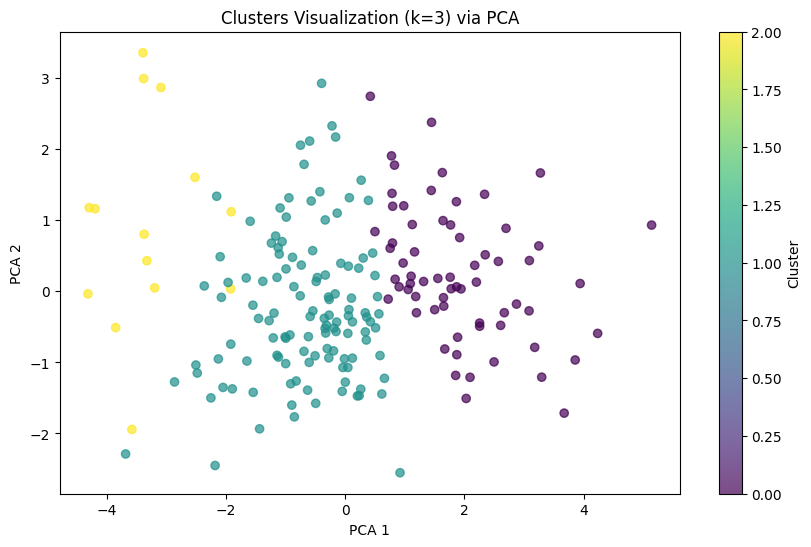

In [21]:
# 2D scatter plot
transformed_final_data = final_pipeline.named_steps['preprocess'].transform(df_for_clustering)
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(transformed_final_data)

plt.figure(figsize=(10,6))
plt.scatter(pca_coords[:,0], pca_coords[:,1], c=final_labels, cmap='viridis', alpha=0.7)
plt.title(f'Clusters Visualization (k={best_k}) via PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

In [22]:
# Cluster counts
print("\nCluster Distribution:")
print(merged_df['Cluster'].value_counts())


Cluster Distribution:
Cluster
1    121
0     65
2     14
Name: count, dtype: int64


In [23]:
# Calculate final DB index for the best_k
final_dbi = davies_bouldin_score(transformed_final_data, final_labels)
print(f"\nDavies-Bouldin Index (k={best_k}): {final_dbi:.3f}")


Davies-Bouldin Index (k=3): 1.367


In [24]:
# Inspect the average profile of each cluster
cluster_summary = merged_df.groupby('Cluster').agg({
    'Total_Spend': 'mean',
    'Num_Transactions': 'mean',
    'Total_Quantity': 'mean',
    'Avg_Spend': 'mean',
    'Recency_days': 'mean',
    'Tenure_days': 'mean'
}).round(2)

print("\nAverage features by cluster:")
print(cluster_summary)


Average features by cluster:
         Total_Spend  Num_Transactions  Total_Quantity  Avg_Spend  \
Cluster                                                             
0            5587.95              7.08           19.55     816.12   
1            2610.58              4.30           10.04     631.30   
2             778.53              1.43            3.64     528.13   

         Recency_days  Tenure_days  
Cluster                             
0               57.49       536.05  
1               66.49       537.60  
2              259.71       459.71  
